In [ ]:
!pip install sliderule

In [5]:
import os
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
import panel as pn
pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import shapely.geometry
import warnings
# grimp and nisar functions
# import grimpfunc as grimp
# import nisardev as nisar
# sliderule functions
import sliderule
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule

# register progress bar and set workers
ProgressBar().register()
dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [6]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [7]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

In [8]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [9]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(geobox)
geodata = ipyleaflet.GeoData(geo_dataframe=geobox)
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [13]:
%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

# create an empty geodataframe
gdf = sliderule.icesat2.__emptyframe()
# for each region of interest
all_regions = m.regions + default_polygon
for poly in all_regions:
    # add polygon from map to sliderule parameters
    params["poly"] = poly 
    # make the request to the SlideRule (ATL06-SR) endpoint
    # and pass it the request parameters to request ATL06 Data  
    gdf = gdf.append(sliderule.icesat2.atl06p(params, asset, version=release))

CPU times: user 3.69 s, sys: 93.6 ms, total: 3.78 s
Wall time: 27.9 s


In [14]:
gdf

,geometry,rms_misfit,gt,spot,dh_fit_dx,pflags,h_sigma,cycle,rgt,distance,w_surface_window_final,segment_id,delta_time,h_mean,n_fit_photons,dh_fit_dy
2018-10-17 22:31:18.140942404,POINT (-108.29593 38.96160),0.089617,50.0,2.0,0.004085,0.0,0.017813,1.0,295.0,4.334678e+06,3.0,216146.0,2.505068e+07,1744.337096,27.0,0.0
2018-10-17 22:31:18.143757644,POINT (-108.29596 38.96178),0.099128,50.0,2.0,0.006902,0.0,0.016049,1.0,295.0,4.334698e+06,3.0,216147.0,2.505068e+07,1744.467918,39.0,0.0
2018-10-17 22:31:18.146572856,POINT (-108.29598 38.96196),0.103003,50.0,2.0,-0.000480,0.0,0.019994,1.0,295.0,4.334718e+06,3.0,216148.0,2.505068e+07,1744.543140,31.0,0.0
2018-10-17 22:31:18.149388076,POINT (-108.29600 38.96214),0.135917,50.0,2.0,-0.005274,0.0,0.030929,1.0,295.0,4.334738e+06,3.0,216149.0,2.505068e+07,1744.458724,21.0,0.0
2018-10-17 22:31:18.152203580,POINT (-108.29602 38.96232),0.150016,50.0,2.0,0.000464,0.0,0.029151,1.0,295.0,4.334758e+06,3.0,216150.0,2.505068e+07,1744.370679,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07 23:39:21.819706624,POINT (-108.12492 38.90929),0.167904,50.0,5.0,0.009148,0.0,0.086102,14.0,1156.0,1.574209e+07,3.0,785952.0,1.319316e+08,2952.043818,34.0,0.0
2022-03-07 23:39:21.854816544,POINT (-108.05170 38.90362),0.140888,10.0,1.0,-0.002198,0.0,0.020707,14.0,1156.0,1.574211e+07,3.0,785953.0,1.319316e+08,1951.241036,50.0,0.0
2022-03-07 23:39:21.857612912,POINT (-108.05172 38.90344),0.142274,10.0,1.0,0.001135,0.0,0.021075,14.0,1156.0,1.574213e+07,3.0,785954.0,1.319316e+08,1951.237739,49.0,0.0
2022-03-07 23:39:21.894484304,POINT (-108.08877 38.90278),0.144253,30.0,3.0,-0.093589,0.0,0.058217,14.0,1156.0,1.574251e+07,3.0,785973.0,1.319316e+08,2509.727947,20.0,0.0


In [15]:
widgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [16]:
#%matplotlib inline
m.GeoData(gdf, column_name=SRwidgets.variable.value, cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, colorbar=True)

In [21]:
import rasterio
import glob

In [25]:
file = glob.glob("*.tif")[0]

In [34]:
img = rasterio.open(file)
array = img.read(1)
trsform = img.transform
lon, lat = trsform * (0,0)

In [35]:
height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)

In [37]:
import pyproj

In [44]:
wgs84=pyproj.CRS("EPSG:4326")
utm=pyproj.CRS("EPSG:32613")
# xx, yy = pyproj.transform(utm, wgs84, np.array(xs).flatten(), np.array(ys).flatten())

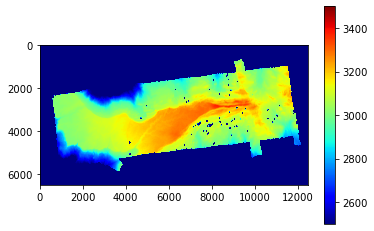

In [61]:
plt.imshow(array, vmin = 2500, vmax = 3500, cmap = "jet")
plt.colorbar()

In [54]:
x, y = pyproj.transform(wgs84, utm, 38.90929, -108.12492)

In [55]:
img.index(y, x)

(1369029, 1364347)

In [56]:
np.shape(array)

(6500, 12450)

In [45]:
gdf

,geometry,rms_misfit,gt,spot,dh_fit_dx,pflags,h_sigma,cycle,rgt,distance,w_surface_window_final,segment_id,delta_time,h_mean,n_fit_photons,dh_fit_dy
2018-10-17 22:31:18.140942404,POINT (-108.29593 38.96160),0.089617,50.0,2.0,0.004085,0.0,0.017813,1.0,295.0,4.334678e+06,3.0,216146.0,2.505068e+07,1744.337096,27.0,0.0
2018-10-17 22:31:18.143757644,POINT (-108.29596 38.96178),0.099128,50.0,2.0,0.006902,0.0,0.016049,1.0,295.0,4.334698e+06,3.0,216147.0,2.505068e+07,1744.467918,39.0,0.0
2018-10-17 22:31:18.146572856,POINT (-108.29598 38.96196),0.103003,50.0,2.0,-0.000480,0.0,0.019994,1.0,295.0,4.334718e+06,3.0,216148.0,2.505068e+07,1744.543140,31.0,0.0
2018-10-17 22:31:18.149388076,POINT (-108.29600 38.96214),0.135917,50.0,2.0,-0.005274,0.0,0.030929,1.0,295.0,4.334738e+06,3.0,216149.0,2.505068e+07,1744.458724,21.0,0.0
2018-10-17 22:31:18.152203580,POINT (-108.29602 38.96232),0.150016,50.0,2.0,0.000464,0.0,0.029151,1.0,295.0,4.334758e+06,3.0,216150.0,2.505068e+07,1744.370679,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07 23:39:21.819706624,POINT (-108.12492 38.90929),0.167904,50.0,5.0,0.009148,0.0,0.086102,14.0,1156.0,1.574209e+07,3.0,785952.0,1.319316e+08,2952.043818,34.0,0.0
2022-03-07 23:39:21.854816544,POINT (-108.05170 38.90362),0.140888,10.0,1.0,-0.002198,0.0,0.020707,14.0,1156.0,1.574211e+07,3.0,785953.0,1.319316e+08,1951.241036,50.0,0.0
2022-03-07 23:39:21.857612912,POINT (-108.05172 38.90344),0.142274,10.0,1.0,0.001135,0.0,0.021075,14.0,1156.0,1.574213e+07,3.0,785954.0,1.319316e+08,1951.237739,49.0,0.0
2022-03-07 23:39:21.894484304,POINT (-108.08877 38.90278),0.144253,30.0,3.0,-0.093589,0.0,0.058217,14.0,1156.0,1.574251e+07,3.0,785973.0,1.319316e+08,2509.727947,20.0,0.0
